# DOE 本番解析用 (base) v6 移動平均・メジアン

### ライブラリの一括インポート

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.setting import load_setting
from funcs.tse import get_ticker_name_list
from structs.res import AppRes

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### ファイル名から日付を返す関数

In [4]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## 初期設定

In [5]:
name_doe = "doe-12b"  # 実験計画名（フォルダ名）
path_doe = os.path.join("..", "doe", f"{name_doe}.csv")

name_code = "7011"  # 銘柄コード
# name_code = "7203"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

df_doe = pd.read_csv(path_doe)
print(df_doe)
factor_doe = list(df_doe.columns)
print(factor_doe)
col_x = factor_doe[0]
col_y = factor_doe[1]

res = AppRes()
dict_setting = load_setting(res, name_code)
df_setting = pd.DataFrame(pd.Series(dict_setting))
df_setting.columns = ["value"]
print("\n設定")
print(df_setting)

x_por = dict_setting[col_x]
y_por = dict_setting[col_y]

# 移動期間
period = 25

     PERIOD_MA_1  PERIOD_MA_2
0             30          300
1             40          300
2             50          300
3             60          300
4             70          300
..           ...          ...
284          150         1100
285          160         1100
286          170         1100
287          180         1100
288          190         1100

[289 rows x 2 columns]
['PERIOD_MA_1', 'PERIOD_MA_2']

設定
                    value
PERIOD_WARMUP      180.00
PERIOD_MA_1         60.00
PERIOD_MA_2        450.00
PERIOD_SLOPE         5.00
THRESHOLD_SLOPE      0.05
PERIOD_RR           30.00
TURBULENCE          35.00
LOSSCUT_1          -25.00
THRESHOLD_PM_MIN    20.00
THRESHOLD_DDR_MIN    0.10
N_MINUS_MAX        240.00


## CSV ファイル一覧の取得

In [6]:
# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
if m := pattern_date.match(file_last):
    date_dir = os.path.join(
        "..", "output", name_doe, f"y{m.group(1)}", m.group(2), m.group(3)
    )
    date_str = date_dir
else:
    date_dir = os.path.join("..", "output", name_doe, "y0000", "00", "00")
    date_str = date_dir
os.makedirs(date_dir, exist_ok=True)
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['result_20250819.csv', 'result_20250820.csv', 'result_20250821.csv', 'result_20250822.csv', 'result_20250825.csv', 'result_20250826.csv', 'result_20250827.csv', 'result_20250828.csv', 'result_20250829.csv', 'result_20250901.csv', 'result_20250902.csv', 'result_20250903.csv', 'result_20250904.csv', 'result_20250905.csv', 'result_20250908.csv', 'result_20250909.csv', 'result_20250910.csv', 'result_20250911.csv', 'result_20250912.csv', 'result_20250916.csv', 'result_20250917.csv', 'result_20250918.csv', 'result_20250919.csv', 'result_20250922.csv', 'result_20250924.csv', 'result_20250925.csv', 'result_20250926.csv', 'result_20250929.csv', 'result_20250930.csv', 'result_20251001.csv', 'result_20251002.csv', 'result_20251003.csv', 'result_20251006.csv', 'result_20251007.csv', 'result_20251008.csv', 'result_20251009.csv', 'result_20251010.csv', 'result_20251014.csv', 'result_20251015.csv', 'result_20251016.csv', 'result_20251017.csv', 'result_20251020.csv', 'result_20251

### 設定情報の保存

In [7]:
# HTML 形式で出力
styled = (
    df_setting.style.format({"value": "{:.3f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_setting.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

## CSV ファイルの読み込み、連結

In [8]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    df_tick = df_tick.astype({"total": float})
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)

list_col = [col_x, col_y, "trade", "total"]
list_col_new = [col_x, col_y, "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

# HTML 形式で出力
styled = (
    df_latest.style.format({"取引回数": "{:d}", "損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_latest_single.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件 [{name_doe}]")
print(df_latest_max)


日毎のシミュレーション結果例（連結前）
                    file  code  trade   total  PERIOD_MA_1  PERIOD_MA_2
0    ticks_20250819.xlsx  7011    100  1100.0           30          300
1    ticks_20250819.xlsx  7011    100  1800.0           40          300
2    ticks_20250819.xlsx  7011     80 -3600.0           50          300
3    ticks_20250819.xlsx  7011     70 -6700.0           60          300
4    ticks_20250819.xlsx  7011     50  2200.0           70          300
..                   ...   ...    ...     ...          ...          ...
284  ticks_20250819.xlsx  7011      8  1800.0          150         1100
285  ticks_20250819.xlsx  7011      4     0.0          160         1100
286  ticks_20250819.xlsx  7011      4     0.0          170         1100
287  ticks_20250819.xlsx  7011      4     0.0          180         1100
288  ticks_20250819.xlsx  7011      2  3000.0          190         1100

[289 rows x 6 columns]

日毎のシミュレーション結果を連結したデータフレーム
                      file  code  trade   total  PERIOD_MA_1  PE

### 本日の条件

## 最終日のデータだけで作成した等高線図

In [9]:
plt.rcParams["font.size"] = 12
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

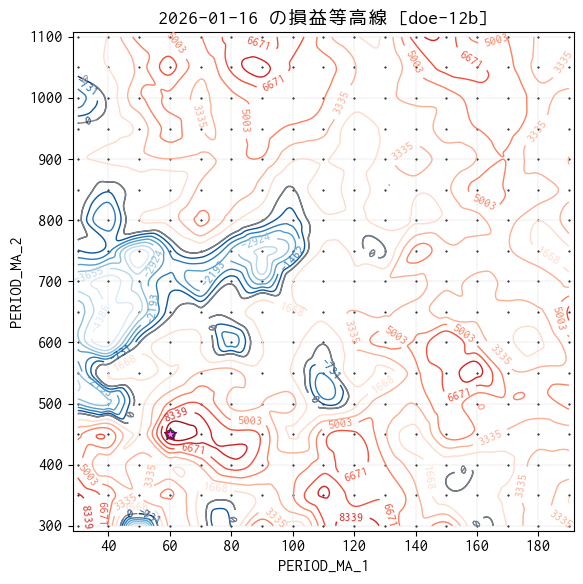

In [10]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

try:
    # z>0 の等高線（暖色）
    levels_pos = np.linspace(0, np.nanmax(Zi), 8)
    cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
    ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
except ValueError as e:
    print("catch ValueError:", e)

try:
    # z<0 の等高線（寒色）
    levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
    cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
    ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
except ValueError as e:
    print("catch ValueError:", e)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.scatter(
    df_latest_max[col_x],
    df_latest_max[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)
ax.scatter(
    x_por,
    y_por,
    marker="*",
    facecolor="#f8f",
    edgecolor="#606",
    s=80,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"{dt_last.date()} の損益等高線 [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

output = os.path.join(date_str, f"{name_code}_contour_single.png")

# plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
# plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

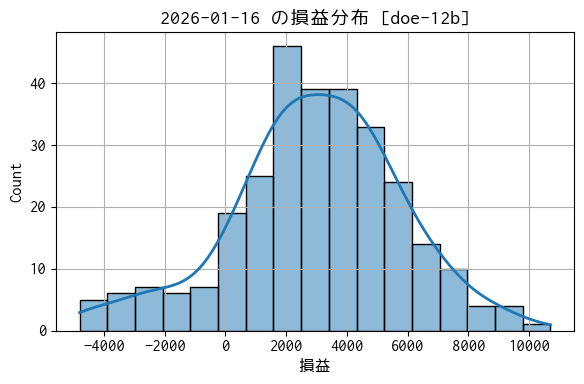

In [11]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df_latest,
    x="損益",
    kde=True,
    line_kws={"linewidth": 2},
    ax=ax,
)
ax.grid()
ax.set_title(f"{dt_last.date()} の損益分布 [{name_doe}]")

plt.tight_layout()
output = os.path.join(date_str, f"{name_code}_hist_single.png")
plt.savefig(output)
plt.show()

## 最大・最小損益（ヒストリカル）

In [12]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高損益")
print(df[df["total"] == total_max])
print("\n最低損益")
print(df[df["total"] == total_min])

最高損益
                      file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2
15165  ticks_20251105.xlsx  7011     54  21000.0           40          700

最低損益
                      file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2
14048  ticks_20251029.xlsx  7011     72 -20800.0           90          800


## 日付 × 条件 で損益を集計

In [13]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で損益")
df_raw = df_raw.astype("float64")
print(df_raw)


df_raw: 日付 x 条件で損益
               0       1       2       3       4       5       6       7    \
2025-08-19  1100.0  1800.0 -3600.0 -6700.0  2200.0  1400.0  1500.0 -3200.0   
2025-08-20  3700.0  3300.0  6000.0  3200.0  4000.0  4000.0  6800.0  7500.0   
2025-08-21  1500.0 -1300.0  1800.0  4000.0  4000.0  3000.0   600.0  1300.0   
2025-08-22 -7400.0 -3500.0 -5100.0 -1100.0 -2700.0  -700.0   600.0  1000.0   
2025-08-25 -3200.0 -1800.0 -1400.0 -1000.0  -400.0  -200.0     0.0  -300.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-09 -3100.0 -2800.0   400.0 -2500.0 -3400.0 -2600.0 -1200.0 -2800.0   
2026-01-13  2600.0   800.0  7700.0  2400.0  4200.0  2800.0  6300.0  9000.0   
2026-01-14  5100.0  1400.0  6300.0  2400.0 -3900.0 -2000.0 -3200.0 -2700.0   
2026-01-15  5000.0  7200.0  6000.0  6600.0  9600.0  9500.0  6300.0  6300.0   
2026-01-16  8900.0  4700.0 -4800.0  3800.0  1300.0  -600.0  6600.0   800.0   

               8       9    ...     279    

## 損益の移動平均のトレンド

In [14]:
# 移動平均
df_ma = df_raw.rolling(window=period, min_periods=1).mean()
print(df_ma)
# データスコープを示す文字列
dt_start = df_ma.index[0]
dt_end = df_ma.index[-1]
title_scope = (
    f"{dict_code[name_code]} ({name_code}) "
    f"from {dt_start.date()} to {dt_end.date()} / "
    f"n={n_day}d / "
    f"rolling={period}d"
)
print("データスコープを示す文字列")
print(title_scope)

               0            1       2            3       4       5    \
2025-08-19  1100.0  1800.000000 -3600.0 -6700.000000  2200.0  1400.0   
2025-08-20  2400.0  2550.000000  1200.0 -1750.000000  3100.0  2700.0   
2025-08-21  2100.0  1266.666667  1400.0   166.666667  3400.0  2800.0   
2025-08-22  -275.0    75.000000  -225.0  -150.000000  1875.0  1925.0   
2025-08-25  -860.0  -300.000000  -460.0  -320.000000  1420.0  1500.0   
...            ...          ...     ...          ...     ...     ...   
2026-01-09   -48.0   260.000000   396.0  -456.000000   104.0   624.0   
2026-01-13    88.0   300.000000   756.0  -200.000000   332.0   868.0   
2026-01-14   376.0   476.000000  1192.0    -4.000000   240.0   960.0   
2026-01-15   532.0   760.000000  1308.0   248.000000   580.0  1276.0   
2026-01-16   956.0  1180.000000  1244.0   412.000000   652.0  1140.0   

                    6            7       8       9    ...     279     280  \
2025-08-19  1500.000000 -3200.000000  -500.0     0.0  ... 

### ランキング（移動平均）

In [15]:
# 最終日の移動平均収益のランキング
ser_ma_ranking = df_ma.iloc[len(df_ma) - 1].sort_values(ascending=False)
n_top = 5

# ベスト条件の抽出
best_ma_conditions = list(ser_ma_ranking.index[:n_top])
df_ma_best = df_latest.iloc[best_ma_conditions].copy()[
    factor_doe + ["取引回数", "損益"]
]
dt = df_ma.index[-1]
df_ma_best["損益(MA)"] = (df_ma.loc[dt:][best_ma_conditions].T)[dt]
print("---\n[Best Conditions with latest MA]")
print(df_ma_best)

# HTML 形式で出力
styled = (
    df_ma_best.style.format(
        {"取引回数": "{:.0f}", "損益": "{:.1f}", "損益(MA)": "{:.1f}"}
    )
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の移動平均収益が負になっている実験条件
negative_ma_conditions = ser_ma_ranking[ser_ma_ranking < 0].index
if len(negative_ma_conditions) > 0:
    df_ma_negative = df_latest.iloc[negative_ma_conditions].copy()
    df_ma_negative["損益(MA)"] = (df_ma.loc[dt:][negative_ma_conditions].T)[dt]
    print("---\n[Bad Conditions with latest MA]")
    print(df_ma_negative)

---
[Best Conditions with latest MA]
    PERIOD_MA_1  PERIOD_MA_2  取引回数       損益  損益(MA)
54           60          450    72  10700.0  2744.0
72           70          500    58   6600.0  2528.0
56           80          450    56   7300.0  2456.0
88           60          550    58   1500.0  2312.0
38           70          400    68   3700.0  2308.0
---
[Bad Conditions with latest MA]
     PERIOD_MA_1  PERIOD_MA_2  取引回数      損益 備考  損益(MA)
197          130          850    24  3200.0     -140.0


### 条件毎の損益トレンド（移動平均）のチャート

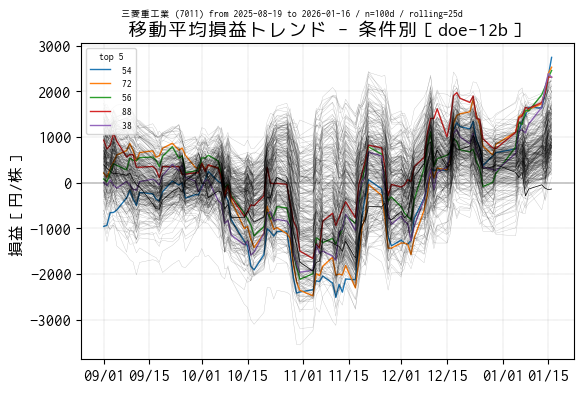

In [16]:
# ---------------------------------------------------------
# 実験条件毎の平均損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_ma[dt_from <= df_ma.index]

for colname in ser_ma_ranking.index:
    if colname in best_ma_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_ma_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.25)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"移動平均損益トレンド - 条件別［{name_doe}］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_ma_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_mean_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 損益の移動メジアンのトレンド

In [17]:
# 移動メジアン
df_mm = df_raw.rolling(window=period, min_periods=1).median()
print(df_mm)

               0       1       2       3       4       5       6       7    \
2025-08-19  1100.0  1800.0 -3600.0 -6700.0  2200.0  1400.0  1500.0 -3200.0   
2025-08-20  2400.0  2550.0  1200.0 -1750.0  3100.0  2700.0  4150.0  2150.0   
2025-08-21  1500.0  1800.0  1800.0  3200.0  4000.0  3000.0  1500.0  1300.0   
2025-08-22  1300.0   250.0  -900.0  1050.0  3100.0  2200.0  1050.0  1150.0   
2025-08-25  1100.0 -1300.0 -1400.0 -1000.0  2200.0  1400.0   600.0  1000.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-09  -800.0   100.0   400.0 -1400.0  -800.0   100.0   300.0   900.0   
2026-01-13  -200.0   200.0   800.0  -300.0  -500.0  1200.0   500.0   900.0   
2026-01-14   400.0   500.0   800.0     0.0  -500.0  1200.0   500.0   900.0   
2026-01-15   400.0   500.0   800.0     0.0  -500.0  1200.0   500.0   900.0   
2026-01-16   700.0   800.0   800.0   300.0   500.0   100.0   500.0   900.0   

               8       9    ...     279     280     281     282

### ランキング（移動メジアン）

In [18]:
# 最終日の移動メジアン収益のランキング
ser_mm_ranking = df_mm.iloc[len(df_mm) - 1].sort_values(ascending=False)
n_top = 10

# ベスト条件の抽出
best_mm_conditions = list(ser_mm_ranking.index[:n_top])
df_mm_best = df_latest.iloc[best_mm_conditions].copy()[
    factor_doe + ["取引回数", "損益"]
]
dt = df_mm.index[-1]
df_mm_best["損益(MM)"] = (df_mm.loc[dt:][best_mm_conditions].T)[dt]
print("---\n[Best Conditions with latest MM]")
print(df_mm_best)

# HTML 形式で出力
styled = (
    df_mm_best.style.format(
        {"取引回数": "{:.0f}", "損益": "{:.1f}", "損益(MM)": "{:.1f}"}
    )
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best_median.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新の移動平均収益が負になっている実験条件
negative_mm_conditions = ser_mm_ranking[ser_mm_ranking < 0].index
if len(negative_mm_conditions) > 0:
    df_mm_negative = df_latest.iloc[negative_mm_conditions].copy()
    df_mm_negative["損益(MM)"] = (df_mm.loc[dt:][negative_mm_conditions].T)[dt]
    print("---\n[Bad Conditions with latest MM]")
    print(df_mm_negative)

---
[Best Conditions with latest MM]
     PERIOD_MA_1  PERIOD_MA_2  取引回数       損益  損益(MM)
54            60          450    72  10700.0  3400.0
85            30          550   100  -3100.0  2800.0
187           30          850    94   1400.0  2700.0
57            90          450    52   6300.0  2700.0
56            80          450    56   7300.0  2500.0
71            60          500    70   5300.0  2500.0
173           60          800    66   2300.0  2500.0
36            50          400    76   4200.0  2300.0
11           140          300    30   3500.0  2300.0
12           150          300    32   5800.0  2300.0
---
[Bad Conditions with latest MM]
     PERIOD_MA_1  PERIOD_MA_2  取引回数      損益 備考  損益(MM)
136           30          700   100 -3700.0     -100.0
248          130         1000    26  2800.0     -100.0
213          120          900    26   800.0     -100.0
179          120          800    22  1000.0     -100.0
212          110          900    28  1800.0     -100.0
197          1

### 条件毎の損益トレンド（移動メジアン）のチャート

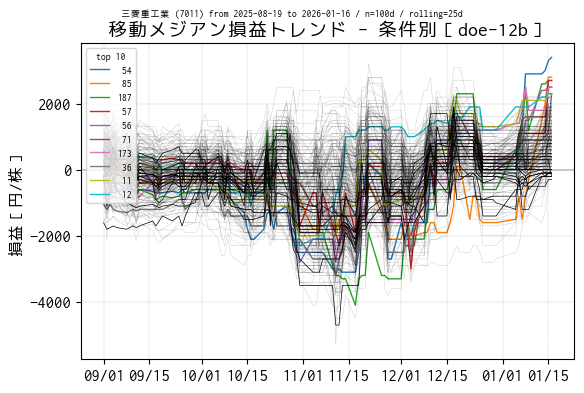

In [19]:
# ---------------------------------------------------------
# 実験条件毎の平均メジアントレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

df_trend = df_mm[dt_from <= df_mm.index]

for colname in ser_mm_ranking.index:
    if colname in best_mm_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_mm_conditions:  # 最新のメジアン収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.25)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"移動メジアン損益トレンド - 条件別［{name_doe}］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_mm_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_median_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

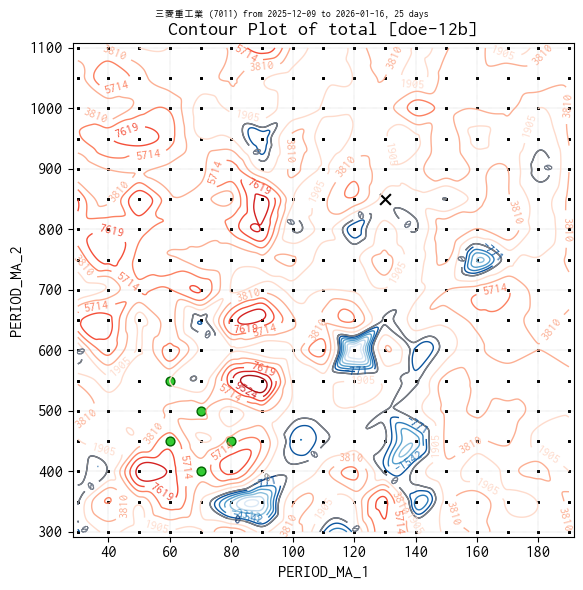

In [20]:
n = len(df_doe) * period
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_z = "total"
x = df[col_x][-n:]
y = df[col_y][-n:]
z = df[col_z][-n:]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"Contour Plot of total [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_ma_best[col_x],
    df_ma_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
if len(negative_ma_conditions) > 0:
    ax.scatter(
        df_ma_negative[col_x],
        df_ma_negative[col_y],
        marker="x",
        color="black",
        s=60,
        zorder=1,
    )

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

title_scope_2 = (
    f"{dict_code[name_code]} ({name_code}) "
    f"from {df_ma.index[-period].date()} to {dt_end.date()}, {period} days"
)

plt.suptitle(title_scope_2, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
output = os.path.join(date_str, f"{name_code}_raw_contour_{target}.png")
plt.savefig(output)
plt.show()